                               Time (s)
Spectral Subtraction (Python)  3.480183
Spectral Subtraction (NumPy)   0.245070
Spectral Subtraction (Numba)   0.339640
Anomaly Detection (Python)     3.114489
Anomaly Detection (NumPy)      0.001498
Anomaly Detection (Numba)      0.085255
Spectrogram (Standard Python)  4.803194
Spectrogram (NumPy Optimized)  0.039276
Spectrogram (Numba Optimized)  0.119990


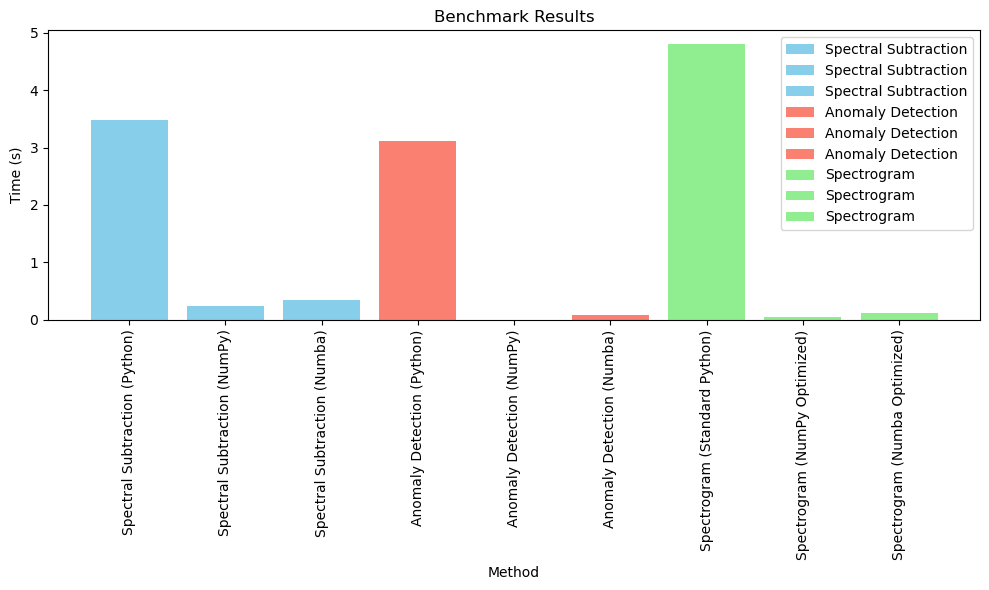

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import get_window, stft, istft
from scipy.fft import fft
import numpy as np
import librosa
from numba import jit

# Load WAV file
file_path = '/home/jas/Downloads/file_example_WAV_10MG.wav'
audio_data, sampling_rate = librosa.load(file_path, sr=None)
sampling_rate = 44100

# Benchmarking Utility
def benchmark(method, *args):
    start = time.time()
    result = method(*args)
    end = time.time()
    return end - start

# --- Spectral Subtraction for Noise Reduction ---
# Standard Python
def spectral_subtraction_python(audio_data, sr):
    f, t, Zxx = stft(audio_data, fs=sr)
    noise = np.mean(np.abs(Zxx[:, :10]), axis=1, keepdims=True)
    noise_reduced = np.abs(Zxx) - noise
    for i in range(noise_reduced.shape[1]):
        for j in range(noise_reduced.shape[0]):
            if noise_reduced[j, i] < 0:
                noise_reduced[j, i] = 0
    _, enhanced_audio = istft(noise_reduced * np.exp(1j * np.angle(Zxx)), fs=sr)
    return enhanced_audio

# NumPy Optimized
def spectral_subtraction_numpy(audio_data, sr):
    f, t, Zxx = stft(audio_data, fs=sr)
    noise = np.mean(np.abs(Zxx[:, :10]), axis=1, keepdims=True)
    noise_reduced = np.abs(Zxx) - noise
    noise_reduced[noise_reduced < 0] = 0
    _, enhanced_audio = istft(noise_reduced * np.exp(1j * np.angle(Zxx)), fs=sr)
    return enhanced_audio

# Numba Optimized
@jit(nopython=True)
def subtract_noise_numba(magnitude, noise, num_frames, num_bins):
    for i in range(num_frames):
        for j in range(num_bins):
            magnitude[j, i] -= noise[j]
            if magnitude[j, i] < 0:
                magnitude[j, i] = 0
    return magnitude

def spectral_subtraction_numba(audio_data, sr):
    f, t, Zxx = stft(audio_data, fs=sr)
    noise = np.mean(np.abs(Zxx[:, :10]), axis=1)
    magnitude = np.abs(Zxx)
    num_frames, num_bins = magnitude.shape
    noise_reduced_magnitude = subtract_noise_numba(magnitude, noise, num_frames, num_bins)
    _, enhanced_audio = istft(noise_reduced_magnitude * np.exp(1j * np.angle(Zxx)), fs=sr)
    return enhanced_audio

# --- Anomaly Detection ---
# Standard Python
def detect_anomalies_standard(audio_data, threshold=0.5):
    anomalies = []
    for i, sample in enumerate(audio_data):
        if abs(sample) > threshold:
            anomalies.append(i)
    return np.array(anomalies)

# NumPy Optimized
def detect_anomalies_numpy(audio_data, threshold=0.5):
    volume = np.abs(audio_data)
    return np.where(volume > threshold)[0]

# Numba Optimized
@jit(nopython=True)
def detect_anomalies_numba(audio_data, threshold=0.5):
    anomalies = []
    for i in range(audio_data.size):
        if np.abs(audio_data[i]) > threshold:
            anomalies.append(i)
    return np.array(anomalies)

# --- Spectrogram Computation ---
# Standard Python
def spectrogram_standard(audio_data, sr, window='hamming', nperseg=1024):
    step = nperseg // 2
    window_values = get_window(window, nperseg)
    spectrogram = []
    for i in range(0, len(audio_data) - nperseg, step):
        frame = audio_data[i:i+nperseg]
        windowed = [frame[j] * window_values[j] for j in range(nperseg)]
        fft_result = fft(windowed)
        power_spectrum = [np.abs(x)**2 for x in fft_result]
        spectrogram.append(power_spectrum)
    return np.array(spectrogram).T

# NumPy Optimized
def spectrogram_numpy(audio_data, sr, nperseg=1024):
    f, t, Zxx = stft(audio_data, fs=sr, window='hamming', nperseg=nperseg)
    return np.abs(Zxx) ** 2

# Numba Optimized
@jit(nopython=True)
def magnitude_squared(arr):
    return np.abs(arr) ** 2

def spectrogram_numba(audio_data, sr, nperseg=1024):
    f, t, Zxx = stft(audio_data, fs=sr, window='hamming', nperseg=nperseg)
    power_spectrum = magnitude_squared(Zxx)
    return power_spectrum

# Benchmark Execution
tasks = {
    "Spectral Subtraction (Python)": spectral_subtraction_python,
    "Spectral Subtraction (NumPy)": spectral_subtraction_numpy,
    "Spectral Subtraction (Numba)": spectral_subtraction_numba,
    "Anomaly Detection (Python)": detect_anomalies_standard,
    "Anomaly Detection (NumPy)": detect_anomalies_numpy,
    "Anomaly Detection (Numba)": detect_anomalies_numba,
    "Spectrogram (Standard Python)": spectrogram_standard,
    "Spectrogram (NumPy Optimized)": spectrogram_numpy,
    "Spectrogram (Numba Optimized)": spectrogram_numba
}

results = {}
for task_name, func in tasks.items():
    time_taken = benchmark(func, audio_data, sampling_rate)
    results[task_name] = time_taken

# Convert results to DataFrame
df = pd.DataFrame.from_dict(results, orient='index', columns=['Time (s)'])
print(df)

# Define color groups for different types of tasks
color_groups = {
    "Spectral Subtraction": "skyblue",
    "Anomaly Detection": "salmon",
    "Spectrogram": "lightgreen"
}

# Plotting
plt.figure(figsize=(10, 6))

# Plotting bars for each task group
for task_name, time_taken in results.items():
    for group_name, color in color_groups.items():
        if group_name in task_name:
            plt.bar(task_name, time_taken, color=color, label=group_name)
            break

plt.title('Benchmark Results')
plt.ylabel('Time (s)')
plt.xlabel('Method')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig('benchmark_results.png')

# Display the graph
plt.show()

